In [10]:
import dgl
import torch
import networkx as nx
import matplotlib.pyplot as plt
import math


In [2]:
import torch.nn as nn
import torch.nn.functional as F


In [3]:
# MINIDATASET
from dgl.data import MiniGCDataset
# A dataset with 80 samples, each graph is
# of size [50, 150]
dataset = MiniGCDataset(80, 50, 150)

# CORA
#from dgl.data import citation_graph as citegrh
#dataset = citegrh.load_cora()

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


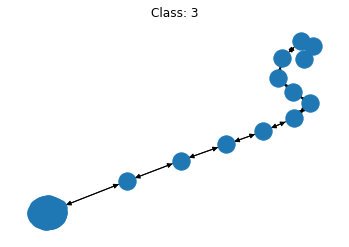

In [26]:
# ELSE
G, label = dataset[30]

# CORA
#G = dgl.DGLGraph(dataset.graph)
#labels = torch.tensor(dataset.labels)

fig, ax = plt.subplots()
nx.draw(G.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()
pass

In [27]:
print('We have %d nodes.' % G.number_of_nodes())
Nnodes = G.number_of_nodes()
print('We have %d edges.' % G.number_of_edges())

We have 119 nodes.
We have 11485 edges.


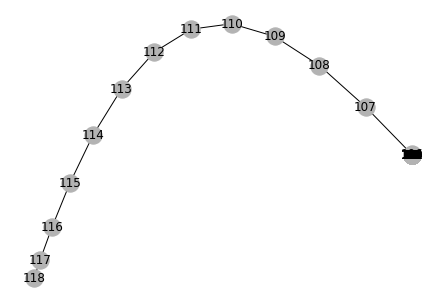

In [28]:
nx.draw_spectral(G.to_networkx().to_undirected(),with_labels=True,node_color=[[.7, .7, .7]])

### Encoding a signal

In [75]:
G.ndata['x'] = torch.arange(Nnodes) 

In [76]:
# Fancy signal
#def signal(nodes): return {'x': torch.sin(nodes.data['x'].type(torch.DoubleTensor) )/nodes.data['x'].type(torch.DoubleTensor) +1}

# EZ signal
def signal(nodes): return {'x': nodes.data['x']+1}
G.apply_nodes(func=signal)

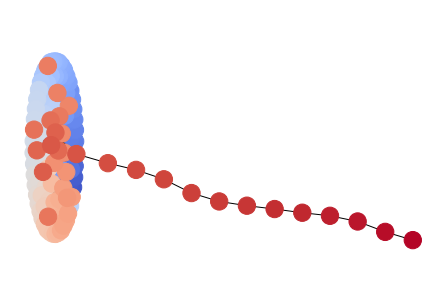

In [77]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=False, cmap=plt.get_cmap('coolwarm'),
                     node_color= G.ndata['x'],)
pass

#### Subsampling

In [83]:
sample = dgl.contrib.sampling.LayerSampler(G,20,2)

In [92]:
sample.fetch(1)

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


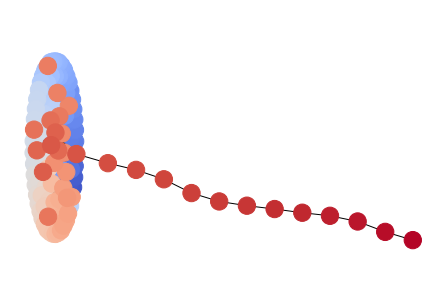

In [87]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = sample.g.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=False, cmap=plt.get_cmap('coolwarm'),
                     node_color= G.ndata['x'],)
pass

## DL PART

In [57]:
# Define the message and reduce function
# NOTE: We ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [58]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(Nnodes, 5, 2)

In [59]:
inputs = torch.eye(Nnodes)
labeled_nodes = torch.tensor([0, Nnodes-1])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [60]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7387
Epoch 1 | Loss: 0.5114
Epoch 2 | Loss: 0.3578
Epoch 3 | Loss: 0.2598
Epoch 4 | Loss: 0.1935
Epoch 5 | Loss: 0.1456
Epoch 6 | Loss: 0.1083
Epoch 7 | Loss: 0.0769
Epoch 8 | Loss: 0.0522
Epoch 9 | Loss: 0.0339
Epoch 10 | Loss: 0.0208
Epoch 11 | Loss: 0.0124
Epoch 12 | Loss: 0.0073
Epoch 13 | Loss: 0.0043
Epoch 14 | Loss: 0.0026
Epoch 15 | Loss: 0.0016
Epoch 16 | Loss: 0.0010
Epoch 17 | Loss: 0.0006
Epoch 18 | Loss: 0.0004
Epoch 19 | Loss: 0.0003
Epoch 20 | Loss: 0.0002
Epoch 21 | Loss: 0.0001
Epoch 22 | Loss: 0.0001
Epoch 23 | Loss: 0.0001
Epoch 24 | Loss: 0.0001
Epoch 25 | Loss: 0.0000
Epoch 26 | Loss: 0.0000
Epoch 27 | Loss: 0.0000
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000


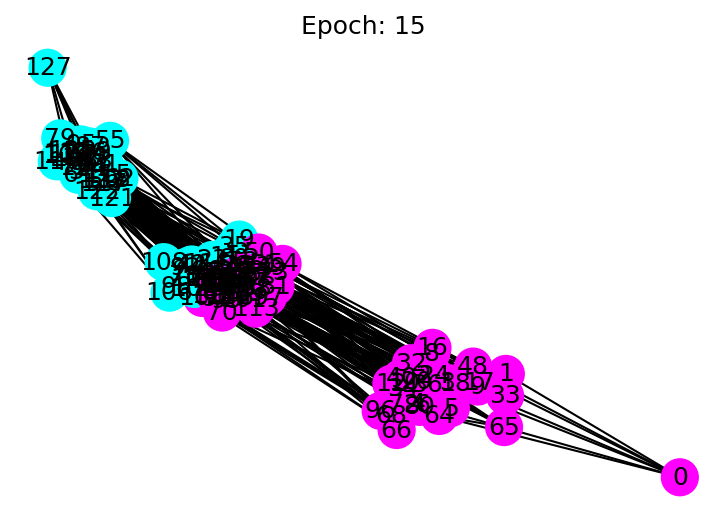

In [61]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(Nnodes):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(15)  # draw the prediction of the first epoch
#plt.close()

In [25]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)